In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
import random
import math
from mpl_toolkits import mplot3d
import seaborn as sns

In [17]:
"""CONSTANTS"""
#the data represented here has been normalized through the formula 
df=pd.read_csv(r"C:\Users\KRISH DIDWANIA\Documents\Country-data.csv")
DF=df.drop(["country"],axis=1)


ARR =DF.to_numpy()

NUMBER_OF_FEATURES = DF.shape[1] 
NUMBER_OF_ELEMENTS = DF.shape[0] 

MAX_CLUSTERS = 12
IDEAL_CLUSTERS = 6

In [18]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 11.9 KB


In [19]:
DF.isnull().sum()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [20]:
DF.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


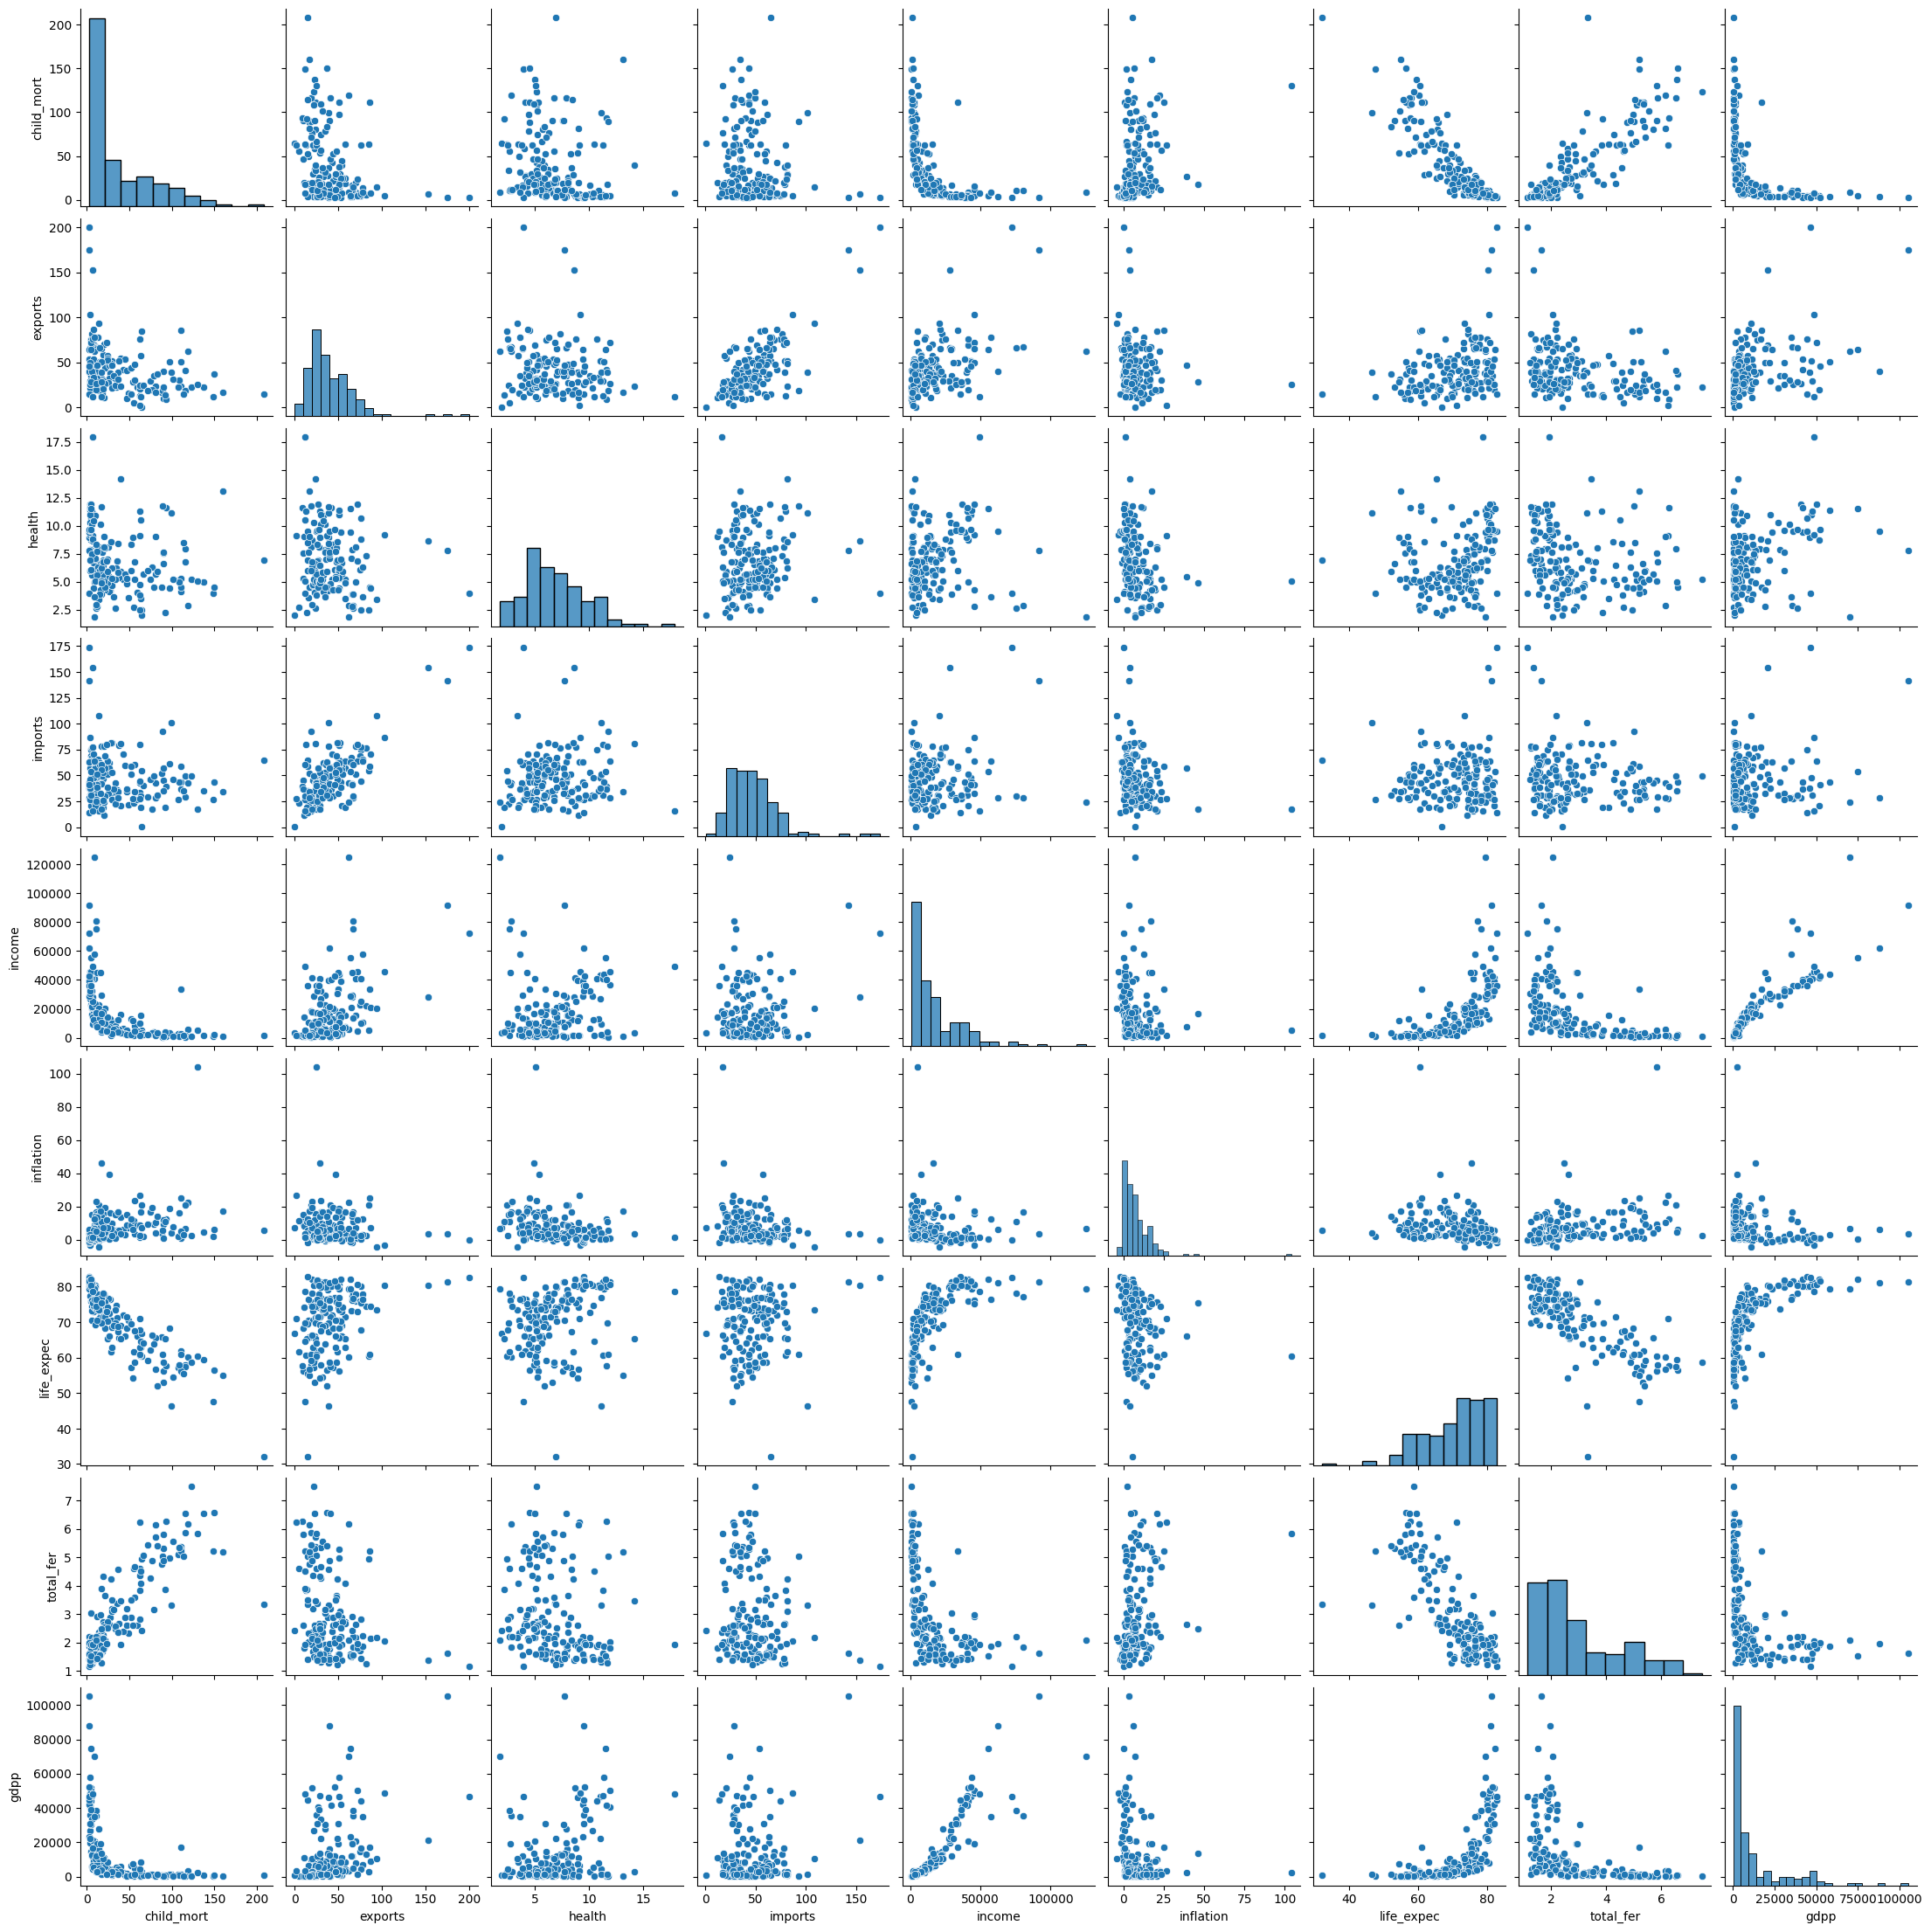

In [21]:
sns.pairplot(DF)

In [22]:
def manhattanDistance(point1, point2):
    distance = 0
    for (x1,x2) in zip(point1, point2):
        absoluteDifference = abs(x1 - x2)
        distance += absoluteDifference
    return distance

def clusterer(numOfClusters): # returns a 2d python array containing the arrays , i.e it returns a list of clusters, and also returns the centroids and the wcss
    
    
    centroids = (DF.sample(n=numOfClusters)).to_numpy()  # selects random points to initialize our values for clusters
    wcss = 10 # within cluster sum of squares
    prevWcss = 0 # wcss of the prev iteration
    ITERATIONS = 3
    
    for i in range(ITERATIONS):
        prevWcss = wcss
        clusters = [[] for i in range(numOfClusters)] # contains clusters for each centroid, i.e the 0th element in the array represents the 0th centroid in the centroids list
        for point in ARR: # assigning points to clusters
            minDistance = 9223372036854775807 # really large value
            minCentroid = 0 # index of the centroid closest to the point
            for i in range(len(centroids)): 
                distance = manhattanDistance(centroids[i], point) # magnitude of the distance vector
                if (distance <= minDistance):
                    minDistance = distance
                    minCentroid = i
            clusters[minCentroid].append(point)
            wcss += minDistance*minDistance

        for i in range(numOfClusters): # finding the mean of every cluster and assigning that as the new centroid of the cluster
            mean = [0 for i in range(NUMBER_OF_FEATURES)]
            for point in clusters[i]:
                for j in range(NUMBER_OF_FEATURES):
                    mean[j] += point[j] / len(clusters[i])
        
            centroids[i] = np.array(mean)
    
    return (clusters, centroids, wcss)


In [23]:
def elbowPlot(maxClusters):
    clusterInfo = {}#dict that has the clusters, centroids, wcss for every numberOfClusters
    x = range(1, maxClusters+1)
    for i in x:
        clusters, centroids, wcss = clusterer(i)
        clusterInfo[i] = (clusters, centroids, wcss)
    
    # plotting the graph
    plt.title("elbow plot to find the optimal number of clusters")
    plt.ylabel("wcss")
    plt.xlabel("clusters")
    wcss = [i[2] for i in clusterInfo.values()]
    plt.plot(x, wcss, '-o')
    plt.show()

    clusters, centroids, wcss = clusterInfo[IDEAL_CLUSTERS][0], clusterInfo[IDEAL_CLUSTERS][1], clusterInfo[IDEAL_CLUSTERS][2]

    return clusters, centroids

In [24]:
def standardizeData(matrix):
    # np.std(array) == ( (sum(1-mean(array))**2 for i in x) / len(x) ) ** 0.5
    return (matrix - np.mean(matrix)) / np.std(matrix)

def covariance(matrix):
    return (matrix.T @ matrix) / (matrix.shape[0] - 1)

def variancePlot(eigenValues):
    eigenValuesTotal = sum(eigenValues)
    explainedVariance = [(i/eigenValuesTotal)*100 for i in eigenValues]
    cumulativeExplainedVariance = np.cumsum(explainedVariance)

    plt.plot(range(NUMBER_OF_FEATURES),cumulativeExplainedVariance, "-o")
    plt.xlabel("number of components")
    plt.ylabel(" cumulative explained variance")
    plt.title("to pick the number of principal components")

    plt.show()
    return cumulativeExplainedVariance[2]

def PCAPlot(matrix, clusterLengths):
    #converting into a numpy array
    matrix = np.array([np.array(point) for point in matrix])
    
    
    # a square matrix giving the covariance(joint variablility of two random variables) between each pair of elements of a given random vector
    covarianceMatrix = covariance(matrix)

    #eigendecomposition of covariance matrix
    eigenValues, eigenVectors = np.linalg.eig(covarianceMatrix)

    #making a list of (eigenValue, eigenVector tuples)
    eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[i, :]) for i in range(len(eigenValues))]

    #sorting in descending order
    eigenPairs.sort(key=lambda i:i[0], reverse=True)
    eigenValuesSorted = np.array([i[0] for i in eigenPairs])
    eigenVectorsSorted = np.array([i[1] for i in eigenPairs])

    cumulativeVariance = variancePlot(eigenValuesSorted)

    #the top two eigenvectors are taken as the principal components
    projectionMatrix = eigenVectorsSorted[:3, :]

    standardizedMatrix = standardizeData(matrix)

    # the standardized matrix is multiplied with the projection matrix in order to get the principal components matrix
    PCAPlotMatrix = standardizedMatrix @ (projectionMatrix.T)
    print(PCAPlotMatrix.shape)

    # plotting the graph
    count = 0
    clusterCount = 0
    PC1 = []
    PC2 = []
    PC3 = []
    fig = plt.figure(figsize = (20,20))
    ax = plt.axes(projection = "3d")
    ax.grid(visible=True, linestyle="-.", linewidth=0.3)
    
    for point in PCAPlotMatrix:
        count += 1

        if (count >= clusterLengths[clusterCount]): # if the number of points is more than the one in the cluster
            ax.scatter3D(PC1, PC2, PC3)
            count = 0
            PC1 = []
            PC2 = []
            PC3 = []
            clusterCount += 1
        PC1.append(point[0])
        PC2.append(point[1])
        PC3.append(point[2])
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title(f"{cumulativeVariance} of variance has been graphed")

    plt.show()

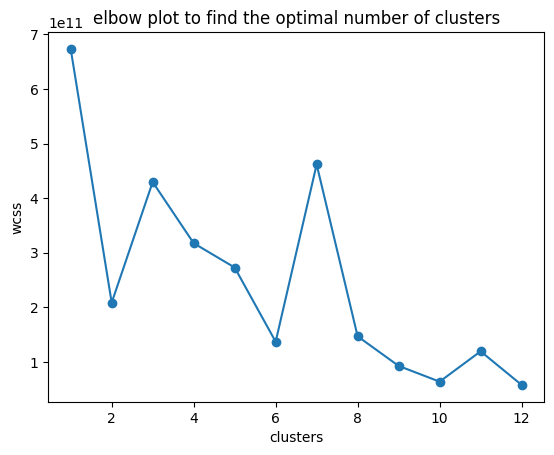

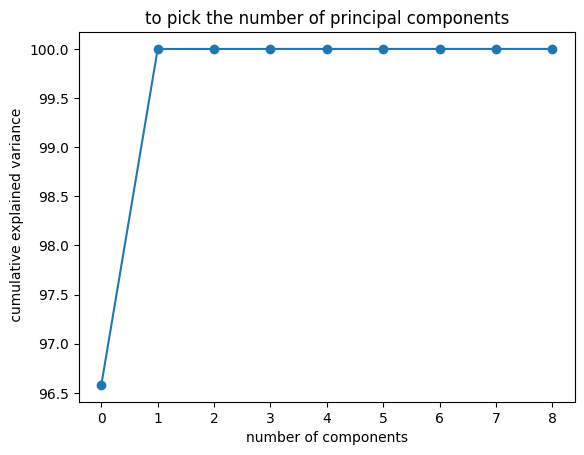

(167, 3)


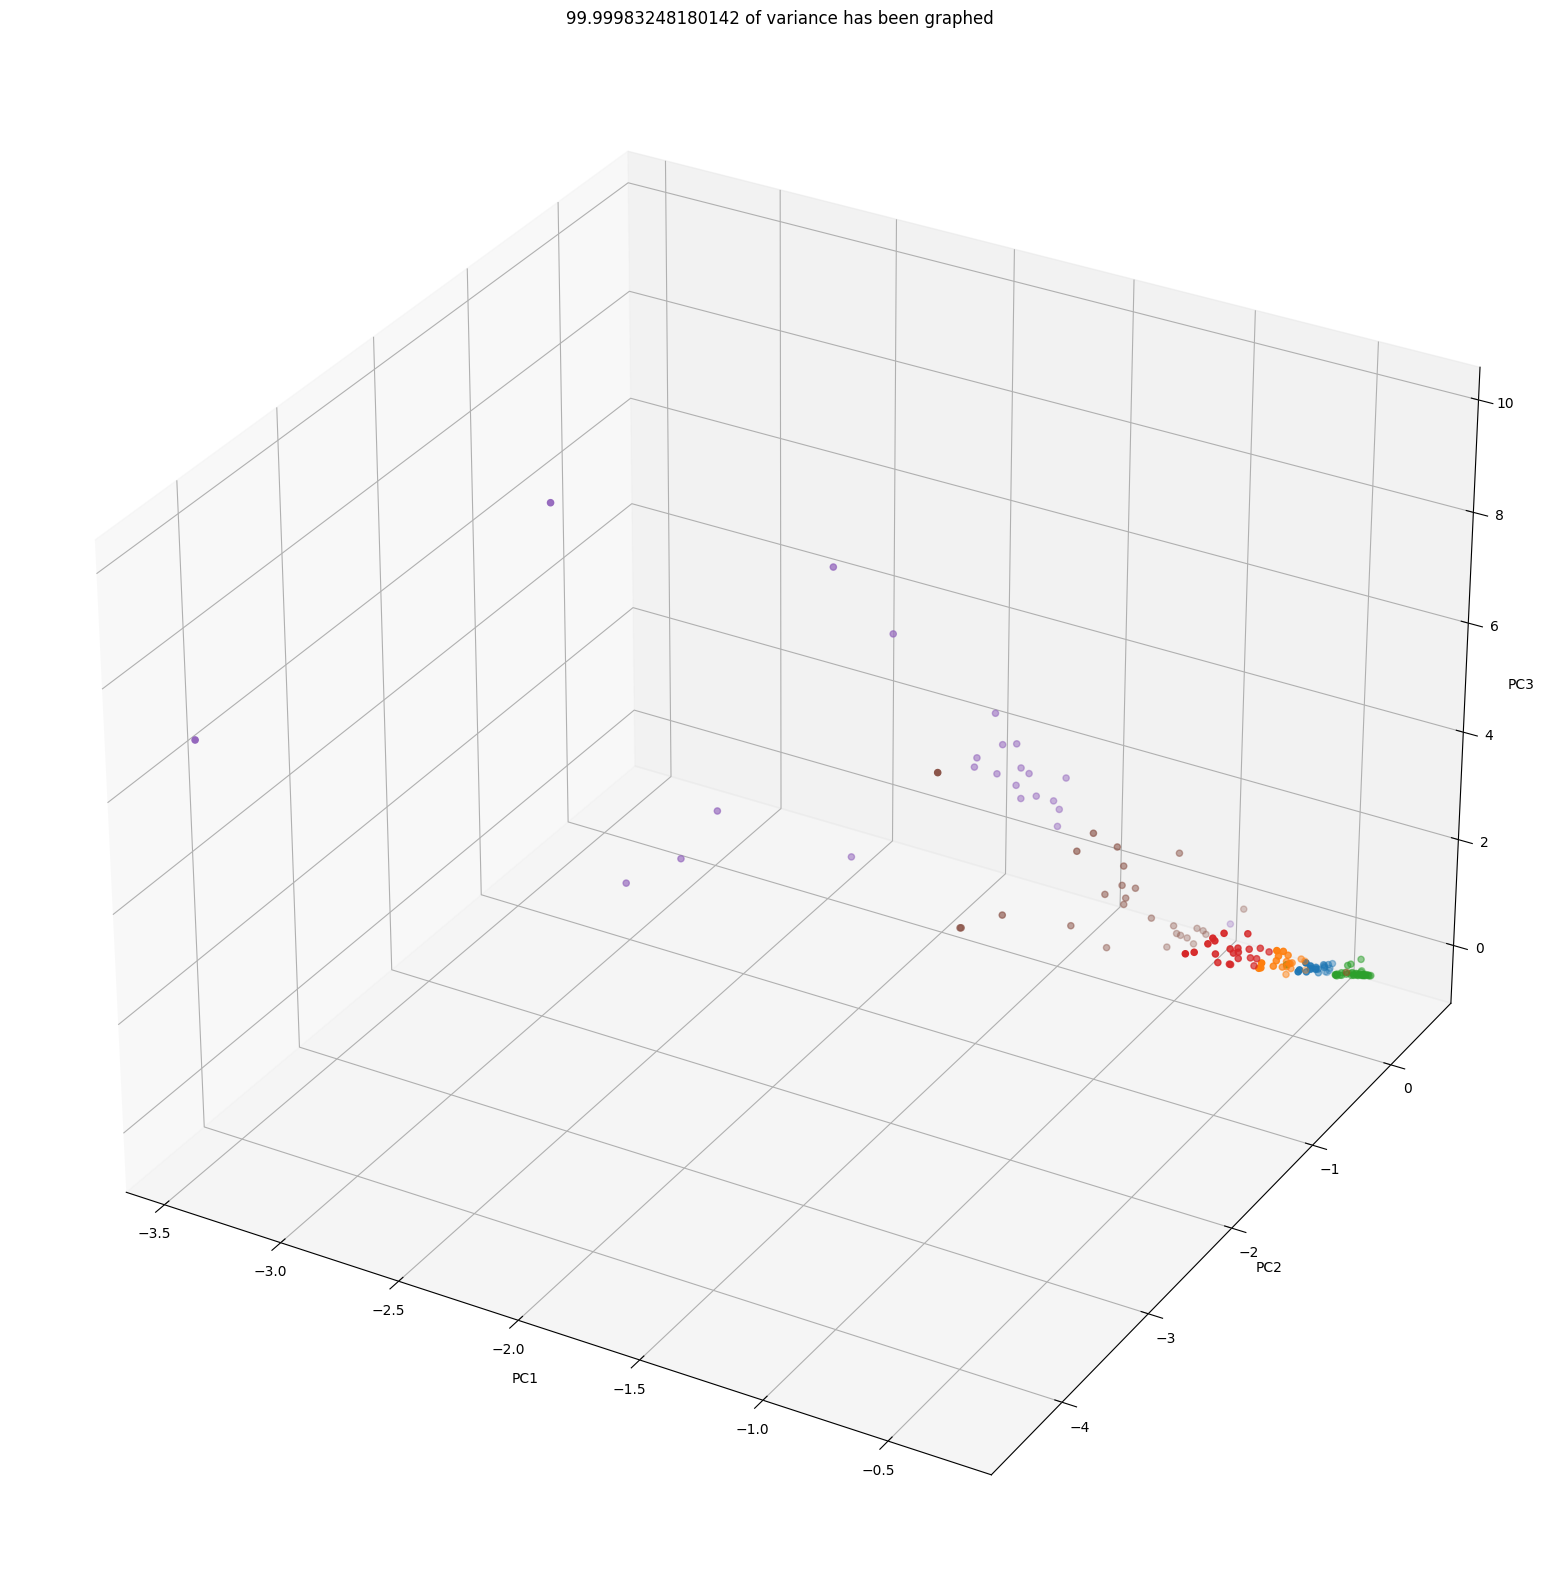

In [25]:
clusters, centroids = elbowPlot(MAX_CLUSTERS)
#converting clusters into np array to simplify calculations
clusterMatrix = [] # removing every point in clusters and putting it in one list
clusterLengths = []
for cluster in clusters:
    clusterLengths.append(len(cluster))
    for point in cluster:
        clusterMatrix.append(point)

PCAPlot(clusterMatrix, clusterLengths)